In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Так как намайненные данные о фильмах носят больше описательный характер, возьмём датасет растворимостей BigSolDB (это датасет для исследования, так что обязательно нужно проводить EDA)

BigSolDB v.2.0 contains 103944 experimentally measured solubility values of 1448 organic compounds in 213 solvents reported in the 1595 literature peer-reviewed articles

The 12 columns of this dataset are explained as follows:

SMILES_Solute — SMILES representation of the solute molecule  
Temperature_K — temperature for the reported solubility value, K  
Solvent — solvent name  
SMILES_Solvent — SMILES representation of the solvent molecule  
Solubility(mole_fraction) — the reported solubility value expressed in mole fraction of solute  
Solubility(mol/L) — the recalculated solubility value expressed in molar concentration of solute (mol/L)  
LogS(mol/L) — decimal logarithm of the recalculated solubility value expressed in molar concentration of solute (mol/L)  
Compound_Name — solute name  
CAS — solute CAS number  
PubChem_CID — solute PubChem_CID  
FDA_Approved — designation if the solute is a FDA approved drug. ‘Yes’ is stated for FDA approved drugs while ‘No’ is stated for others.  
Source — DOI of a data source for given values  
An addition dataset of solvents densities values is also presented.  

The 4 columns of this dataset are explained as follows:  

Solvent — solvent name  
Temperature_K — temperature for the reported density value, K  
Density_g/cm^3 – the reported density value  
Source — data source for given values  
An additional note - the values in columns 'Solubility(mol/L)' and 'LogS(mol/L)' were recalculated from the mole fraction values reported in the source articles ('Solubility(mole_fraction)' column), using the densitites of solvents expressed in BigSolDBv2.0_densities.csv.  

### Предварительный обзор

In [11]:
url = "https://zenodo.org/records/15094979/files/BigSolDBv2.0.csv?download=1"
df = pd.read_csv(url)

In [12]:
%matplotlib inline
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

Общая сводка по данным

In [13]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (103944, 12)
Columns: ['SMILES_Solute', 'Temperature_K', 'Solvent', 'SMILES_Solvent', 'Solubility(mole_fraction)', 'Solubility(mol/L)', 'LogS(mol/L)', 'Compound_Name', 'CAS', 'PubChem_CID', 'FDA_Approved', 'Source']


,SMILES_Solute,Temperature_K,Solvent,SMILES_Solvent,Solubility(mole_fraction),Solubility(mol/L),LogS(mol/L),Compound_Name,CAS,PubChem_CID,FDA_Approved,Source
0,CCCCCCCCCCCCCCCCCCCC(=O)OCCO,311.2500,ethanol,CCO,0.0006,0.0101,-1.9964,Ethylene glycol monoeicosate,26158-80-5,538813.0000,No,10.1007/bf00649573
1,CCCCCCCCCCCCCCCCCCCC(=O)OCCO,314.6500,ethanol,CCO,0.0012,0.0201,-1.6968,Ethylene glycol monoeicosate,26158-80-5,538813.0000,No,10.1007/bf00649573
2,CCCCCCCCCCCCCCCCCCCC(=O)OCCO,319.1500,ethanol,CCO,0.0020,0.0334,-1.4768,Ethylene glycol monoeicosate,26158-80-5,538813.0000,No,10.1007/bf00649573
3,CCCCCCCCCCCCCCCCCCCC(=O)OCCO,322.1500,ethanol,CCO,0.0050,0.0834,-1.0791,Ethylene glycol monoeicosate,26158-80-5,538813.0000,No,10.1007/bf00649573
4,CCCCCCCCCCCCCCCCCCCC(=O)OCCO,324.1500,ethanol,CCO,0.0139,0.2333,-0.6321,Ethylene glycol monoeicosate,26158-80-5,538813.0000,No,10.1007/bf00649573


Проведём обзор данных: типы, базовая статистика, пропуски

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103944 entries, 0 to 103943
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SMILES_Solute              103944 non-null  object 
 1   Temperature_K              103944 non-null  float64
 2   Solvent                    103944 non-null  object 
 3   SMILES_Solvent             103944 non-null  object 
 4   Solubility(mole_fraction)  103944 non-null  float64
 5   Solubility(mol/L)          100983 non-null  float64
 6   LogS(mol/L)                100983 non-null  float64
 7   Compound_Name              103944 non-null  object 
 8   CAS                        96488 non-null   object 
 9   PubChem_CID                101351 non-null  float64
 10  FDA_Approved               103944 non-null  object 
 11  Source                     103944 non-null  object 
dtypes: float64(5), object(7)
memory usage: 9.5+ MB


PubChem_CID это ID, а не числовая характеристика, так что лучше преобразовать в строку, чтобы оно не анализировалось как число

In [27]:
if "PubChem_CID" in df.columns:
    df["PubChem_CID"] = df["PubChem_CID"].astype(str)

### Пропуски - completeness

Больше всего пропусков приходится на в целом таргетные данные Solulubility и LogS растворимости. Также порядка 7% пропусков приходится на CAS

In [28]:
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:", missing)

# Доля пропусков
missing_frac = (df.isnull().sum() / len(df)).sort_values(ascending=False)
print("Missing fractions per column:", missing_frac)

Missing values per column: CAS                          7456
Solubility(mol/L)            2961
LogS(mol/L)                  2961
SMILES_Solute                   0
Temperature_K                   0
Solvent                         0
SMILES_Solvent                  0
Solubility(mole_fraction)       0
Compound_Name                   0
PubChem_CID                     0
FDA_Approved                    0
Source                          0
dtype: int64
Missing fractions per column: CAS                         0.0717
Solubility(mol/L)           0.0285
LogS(mol/L)                 0.0285
SMILES_Solute               0.0000
Temperature_K               0.0000
Solvent                     0.0000
SMILES_Solvent              0.0000
Solubility(mole_fraction)   0.0000
Compound_Name               0.0000
PubChem_CID                 0.0000
FDA_Approved                0.0000
Source                      0.0000
dtype: float64


### Первичный анализ и распределения значений

Температуры распределены нормальным образом, как и LogS значений растворимости 

Numerical columns: ['Temperature_K', 'Solubility(mole_fraction)', 'Solubility(mol/L)', 'LogS(mol/L)']


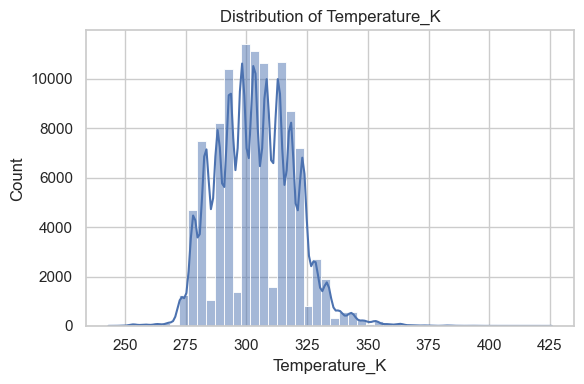

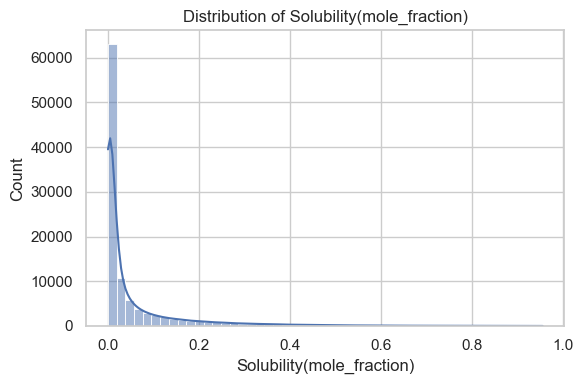

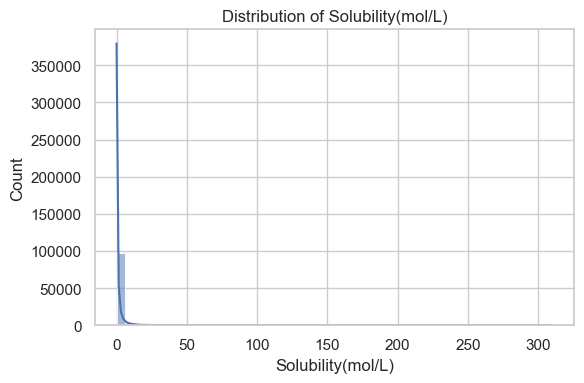

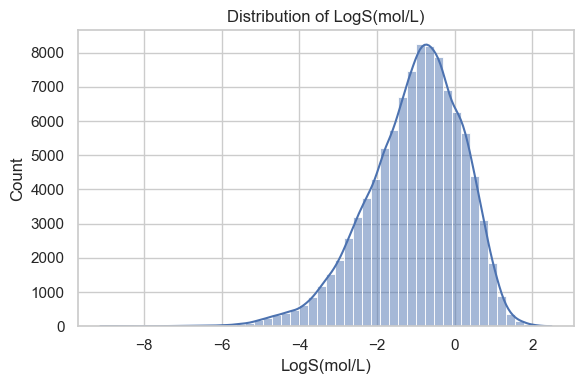

In [29]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", num_cols)

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### Корреляция числовых признаков

Забавно, что Solulubility mole_fraction и Solulubility mol/L, как и LogS не скоррелированы на единичку. То есть формулы перевода не линейные :)) 

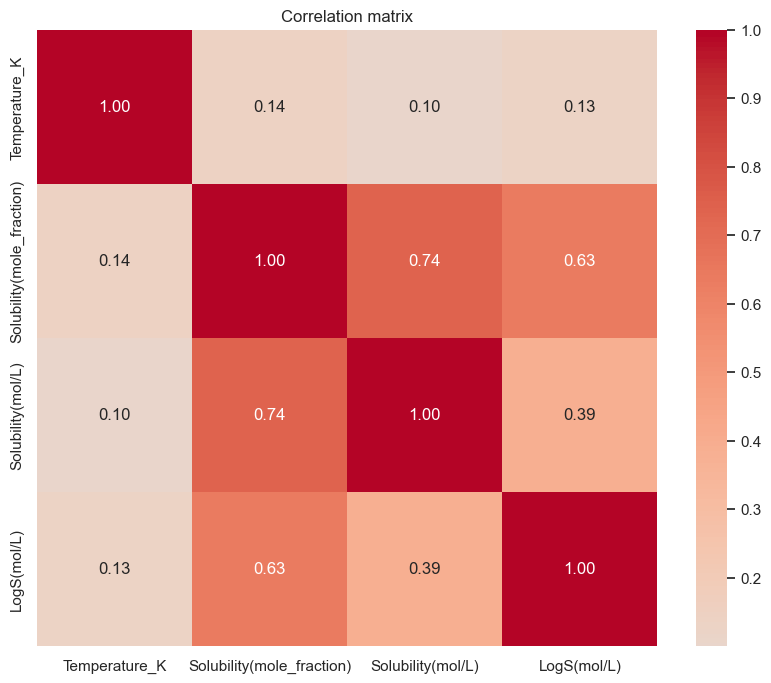

In [30]:
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()

### Уникальные значения - uniqueness

Видим, что достаточно много SMILES формул, которые соответствуют записям в датасете с различными температурами. Также видно, что этанол выступает самым частым растворителем

In [40]:
# Полные дубликаты строк
total_duplicates = df.duplicated().sum()
print(f"Количество полных дублей строк в датасете: {total_duplicates}")

# Проверим дубли по химическому представлению соединения растворяемого вещества (SMILES_Solvent)
if "SMILES_Solvent" in df.columns:
    smiles_duplicates = df["SMILES_Solvent"].duplicated().sum()
    unique_smiles = df["SMILES_Solvent"].nunique()
    total_smiles = len(df["SMILES_Solvent"])
    print(f"Дубликатов по SMILES: {smiles_duplicates}")
    print(f"Уникальных SMILES: {unique_smiles} из {total_smiles} записей")
    
    # Если нужно — выведем примеры дублей
    duplicated_smiles = df[df["SMILES_Solvent"].duplicated(keep=False)].sort_values("SMILES_Solvent")
    print(f"Примеры дублей SMILES:")
    display(duplicated_smiles.head(10))

Количество полных дублей строк в датасете: 0
Дубликатов по SMILES: 103735
Уникальных SMILES: 209 из 103944 записей
Примеры дублей SMILES:


,SMILES_Solute,Temperature_K,Solvent,SMILES_Solvent,Solubility(mole_fraction),Solubility(mol/L),LogS(mol/L),Compound_Name,CAS,PubChem_CID,FDA_Approved,Source
97654,O=C(NC(Cc1cc(=O)[nH]c2ccccc12)C(=O)O)c1ccc(Cl)cc1,298.1500,PEG-400,-,0.0026,NaN,NaN,Rebamipide,90098-04-7,5042.0,No,10.1016/j.molliq.2019.111041
97650,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,313.2000,PEG-400,-,0.0058,NaN,NaN,Osimertinib,1421373-65-0,71496458.0,Yes,10.1016/j.molliq.2019.03.128
97651,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,318.2000,PEG-400,-,0.0073,NaN,NaN,Osimertinib,1421373-65-0,71496458.0,Yes,10.1016/j.molliq.2019.03.128
97652,O=C(NC(Cc1cc(=O)[nH]c2ccccc12)C(=O)O)c1ccc(Cl)cc1,288.1500,PEG-400,-,0.0024,NaN,NaN,Rebamipide,90098-04-7,5042.0,No,10.1016/j.molliq.2019.111041
97653,O=C(NC(Cc1cc(=O)[nH]c2ccccc12)C(=O)O)c1ccc(Cl)cc1,293.1500,PEG-400,-,0.0025,NaN,NaN,Rebamipide,90098-04-7,5042.0,No,10.1016/j.molliq.2019.111041
97581,CN(Cc1ccccc1)CN1C(=O)C(=NNC(=O)c2ccccc2OCc2ccc...,318.1500,PEG-400,-,0.0114,NaN,NaN,N′-(1-(n-(methyl) benzylaminomethyl)-2-oxoindo...,1884472-26-7,137175079.0,No,10.1016/j.molliq.2016.04.068
97655,O=C(NC(Cc1cc(=O)[nH]c2ccccc12)C(=O)O)c1ccc(Cl)cc1,303.1500,PEG-400,-,0.0028,NaN,NaN,Rebamipide,90098-04-7,5042.0,No,10.1016/j.molliq.2019.111041
97656,O=C(NC(Cc1cc(=O)[nH]c2ccccc12)C(=O)O)c1ccc(Cl)cc1,308.1500,PEG-400,-,0.0029,NaN,NaN,Rebamipide,90098-04-7,5042.0,No,10.1016/j.molliq.2019.111041
97649,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,308.2000,PEG-400,-,0.0042,NaN,NaN,Osimertinib,1421373-65-0,71496458.0,Yes,10.1016/j.molliq.2019.03.128
97657,COc1ccccc1OCCNCC(O)COc1cccc2[nH]c3ccccc3c12,288.1500,PEG-400,-,0.0501,NaN,NaN,Carvedilol,72956-09-3,2585.0,Yes,10.1016/j.molliq.2019.111622


Уникальные 1448
Топ-10 частых значений SMILES_Solute
CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1                                                                   416
C[C@@H]1CC[C@@]2(OC1)O[C@H]1C[C@H]3[C@@H]4CC=C5C[C@@H](O)CC[C@]5(C)[C@H]4CC[C@]3(C)[C@H]1[C@@H]2C       380
Cn1c(=O)c2c(ncn2CC2OCCO2)n(C)c1=O                                                                       357
CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1                                                                  313
O=C(O)c1ccccc1                                                                                          311
O=[N+]([O-])N1C2C3N([N+](=O)[O-])C1C1N([N+](=O)[O-])C(C(N1[N+](=O)[O-])N3[N+](=O)[O-])N2[N+](=O)[O-]    295
CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1                                                             272
Nc1ccc(S(N)(=O)=O)cc1                                                                                   267
O=c1[nH]cc(F)c(=O)[nH]1                                                            

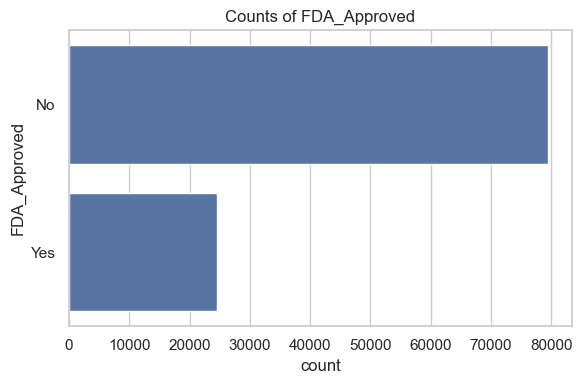

Уникальные 1595
Топ-10 частых значений Source
10.1021/je100341q               568
10.1016/j.molliq.2018.12.081    392
10.1021/je1009812               340
10.1016/j.jct.2013.12.031       324
10.1016/j.jct.2014.05.009       288
10.1016/j.molliq.2022.120365    247
10.1016/j.molliq.2016.08.074    245
10.1021/acs.jced.7b00316        236
10.1021/acs.jced.3c00237        234
10.1021/acs.jced.9b00842        215
Name: count, dtype: int64



In [31]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

for col in cat_cols:
    print("Уникальные", df[col].nunique())
    print("Топ-10 частых значений", df[col].value_counts().head(10))
    print()

    # Визуализация частот (для небольшого числа категорий)
    if df[col].nunique() < 20:
        plt.figure(figsize=(6,4))
        sns.countplot(y=col, data=df, order=df[col].value_counts().index[:15])
        plt.title(f"Counts of {col}")
        plt.tight_layout()
        plt.show()

### Оценка выбросов

В целом, немного странно, что количество выбросов по разным шкалам отличается, хотя у mole_fraction и mol_L должно быть приблизительно одинаковым. А вот с LogS будто бы можно понять, потому что шкала логарифмическая?

In [32]:
def detect_outliers_iqr(data, col, k=1.5):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return data[(data[col] < lower) | (data[col] > upper)]

print("Количество выбросов по числовым признакам:")
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: выбросов = {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

Количество выбросов по числовым признакам:
Temperature_K: выбросов = 1147 (1.10%)
Solubility(mole_fraction): выбросов = 14026 (13.49%)
Solubility(mol/L): выбросов = 14592 (14.04%)
LogS(mol/L): выбросов = 1544 (1.49%)


### Обработка пропусков

In [33]:
threshold = 0.05
cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
print("Columns to drop (too many missing):", cols_to_drop)

df2 = df.drop(columns=cols_to_drop)

# Числовые можем заполнять медианой
for col in num_cols:
    if col in df2.columns:
        if df2[col].isnull().any():
            median_val = df2[col].median()
            df2[col].fillna(median_val, inplace=True)

# Для категориальных можно заполнить модой или “Unknown”
for col in cat_cols:
    if col in df2.columns:
        if df2[col].isnull().any():
            mode_val = df2[col].mode().iloc[0]
            df2[col].fillna(mode_val, inplace=True)

Columns to drop (too many missing): ['CAS']


C:\Users\teren\AppData\Local\Temp\ipykernel_23012\3433827965.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2[col].fillna(median_val, inplace=True)


### Анализ групп

In [60]:
sol_col = "Solubility(mol/L)"

if {"SMILES_Solvent", sol_col}.issubset(df.columns):
    stats_by_solvent = (
        df.groupby("Solvent")[sol_col]
        .agg(
            count="count",
            n_unique=lambda x: x.nunique(),
            mean="mean",
            median="median",
            std="std",
            min="min",
            max="max"
        )
        .sort_values("count", ascending=False)
    )

    print("Статистика по растворителям (Solvent):")
    display(stats_by_solvent.head(20))

else:
    print(f"Не найдены колонки: 'Solvent' и '{sol_col}'")

if {"SMILES_Solute", sol_col}.issubset(df.columns):
    stats_by_solute = (
        df.groupby("SMILES_Solute")[sol_col]
        .agg(
            count="count",
            n_unique=lambda x: x.nunique(),
            mean="mean",
            median="median",
            std="std",
            min="min",
            max="max"
        )
        .sort_values("count", ascending=False)
    )

    print("Статистика по растворимым веществам (SMILES_Solute):")
    display(stats_by_solute.head(20))

else:
    print(f"Не найдены колонки: 'SMILES_Solute' и '{sol_col}'")


Статистика по растворителям (Solvent):


,count,n_unique,mean,median,std,min,max
Solvent,,,,,,,
ethanol,10271,10125,1.1548,0.1087,4.7915,0.0000,173.2408
methanol,8220,8133,1.6771,0.1848,6.3175,0.0000,246.1129
isopropanol,7298,7192,0.7453,0.0669,4.1009,0.0000,217.5427
water,6814,6730,1.7767,0.0184,6.4268,0.0000,141.2494
ethyl acetate,6802,6743,1.0005,0.1431,3.1504,0.0000,65.2742
n-propanol,6616,6552,0.9170,0.1060,4.0987,0.0000,192.4017
acetone,6062,6017,1.6647,0.2478,5.3455,0.0000,126.7973
n-butanol,5613,5576,0.7942,0.0880,3.4211,0.0000,125.0804
acetonitrile,5251,5204,1.3097,0.1319,6.8883,0.0000,309.7926


Статистика по растворимым веществам (SMILES_Solute):


,count,n_unique,mean,median,std,min,max
SMILES_Solute,,,,,,,
CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,416,416,0.3763,0.1874,0.4614,0.0336,2.5678
Cn1c(=O)c2c(ncn2CC2OCCO2)n(C)c1=O,348,348,0.1349,0.0909,0.1354,0.0051,0.9432
C[C@@H]1CC[C@@]2(OC1)O[C@H]1C[C@H]3[C@@H]4CC=C5C[C@@H](O)CC[C@]5(C)[C@H]4CC[C@]3(C)[C@H]1[C@@H]2C,339,339,0.0583,0.0463,0.0493,0.0001,0.4095
CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,313,313,0.1078,0.0151,0.2496,0.0000,1.5257
CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1,272,272,3.1715,2.1862,3.0978,0.0000,14.3742
Nc1ccc(S(N)(=O)=O)cc1,267,267,0.2653,0.0362,0.4576,0.0000,1.8869
O=c1[nH]cc(F)c(=O)[nH]1,258,258,0.0420,0.0259,0.0437,0.0027,0.2207
CN(C)CCC=C1c2ccccc2CCc2ccccc21.Cl,248,248,0.7967,0.4706,1.1083,0.0078,6.1973
Cc1c(C(=O)O)cccc1[N+](=O)[O-],244,244,0.6802,0.4741,0.7787,0.0847,6.8526
